Importing required packages

In [1]:
import pandas as pd
import numpy as np


Reading the file

In [ ]:
df = pd.read_csv("spam.csv", encoding="latin1")


Showing the csv file content

In [26]:
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [29]:
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['label', 'message']

df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Preprocess Data

In [32]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     -------------------------------------  41.0/41.5 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 41.5/41.5 kB 505.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.5 MB 1.9 MB/s eta 0:00:01
   -- ------------------------------------- 0.1/1.5 MB 919.0 kB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.5 MB 1.5 MB/s eta 0:00:01
   ------ --------------------------------- 0.3/1.5 MB 1.4 MB/s eta 0:00:01
   ----------- ---------------------------- 0.5/1.5 MB 2.0 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.5 MB 2.3 MB/s eta 0:00:01
   -------------------------- ------------- 1.0/1.5 MB 3.2 MB/s eta 0:00:01
   ------------------------------------ --- 1.4/1.5 MB 3.8 MB/s eta 0:00:01
   -------------

In [33]:
import string
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [34]:
df['message'] = df.message.apply(text_process)
df.head()

,label,message
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif oni
2,spam,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,dun say early hor c already say
4,ham,Nah think goes usf lives around though


Mapping the labels to be numeric instead of strings

In [35]:
df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,message
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif oni
2,1,Free entry wkly comp win FA Cup final tkts 21s...
3,0,dun say early hor c already say
4,0,Nah think goes usf lives around though


Tokenize the dataset

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 3: Split data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)


In [63]:
# Step 2: fit ONLY on training data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_raw).toarray()


# Step 3: transform test data using the same vocabulary
X_test = vectorizer.transform(X_test_raw).toarray()

In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4457, 8265), (1115, 8265), (4457,), (1115,))

In [64]:
class MultiNB:
    def __init__(self,alpha=1):
        self.alpha = alpha

    def _prior(self): # CHECKED
        """
        Calculates prior for each unique class in y. P(y)
        """
        P = np.zeros((self.n_classes_))
        _, self.dist = np.unique(self.y,return_counts=True)
        for i in range(self.classes_.shape[0]):
            P[i] = self.dist[i] / self.n_samples
        return P

    def fit(self, X, y): # CHECKED, matches with sklearn
        """
        Calculates the following things-
            class_priors_ is list of priors for each y.
            N_yi: 2D array. Contains for each class in y, the number of time each feature i appears under y.
            N_y: 1D array. Contains for each class in y, the number of all features appear under y.

        params
        ------
        X: 2D array. shape(n_samples, n_features)
            Multinomial data
        y: 1D array. shape(n_samples,). Labels must be encoded to integers.
        """
        self.y = y
        self.n_samples, self.n_features = X.shape
        self.classes_ = np.unique(y)
        self.n_classes_ = self.classes_.shape[0]
        self.class_priors_ = self._prior()

        # distinct values in each features
        self.uniques = []
        for i in range(self.n_features):
            tmp = np.unique(X[:,i])
            self.uniques.append( tmp )

        self.N_yi = np.zeros((self.n_classes_, self.n_features)) # feature count
        self.N_y = np.zeros((self.n_classes_)) # total count
        for i in self.classes_: # x axis
            indices = np.argwhere(self.y==i).flatten()
            columnwise_sum = []
            for j in range(self.n_features): # y axis
                columnwise_sum.append(np.sum(X[indices,j]))

            self.N_yi[i] = columnwise_sum # 2d
            self.N_y[i] = np.sum(columnwise_sum) # 1d

    def _theta(self, x_i, i, h):
        """
        Calculates theta_yi. aka P(xi | y) using eqn(1) in the notebook.

        params
        ------
        x_i: int.
            feature x_i

        i: int.
            feature index.

        h: int or string.
            a class in y

        returns
        -------
        theta_yi: P(xi | y)
        """

        Nyi = self.N_yi[h,i]
        Ny  = self.N_y[h]

        numerator = Nyi + self.alpha
        denominator = Ny + (self.alpha * self.n_features)

        return  (numerator / denominator)**x_i

    def _likelyhood(self, x, h):
        """
        Calculates P(E|H) = P(E1|H) * P(E2|H) .. * P(En|H).

        params
        ------
        x: array. shape(n_features,)
            a row of data.
        h: int.
            a class in y
        """
        tmp = []
        for i in range(x.shape[0]):
            tmp.append(self._theta(x[i], i,h))

        return np.prod(tmp)

    def predict(self, X):
        samples, features = X.shape
        self.predict_proba = np.zeros((samples,self.n_classes_))

        for i in range(X.shape[0]):
            joint_likelyhood = np.zeros((self.n_classes_))

            for h in range(self.n_classes_):
                joint_likelyhood[h]  = self.class_priors_[h] * self._likelyhood(X[i],h) # P(y) P(X|y)

            denominator = np.sum(joint_likelyhood)

            for h in range(self.n_classes_):
                numerator = joint_likelyhood[h]
                self.predict_proba[i,h] = (numerator / denominator)

        indices = np.argmax(self.predict_proba,axis=1)
        return self.classes_[indices]

In [65]:
# Step 4: Train your model
model_MultiNB = MultiNB()
model_MultiNB.fit(X_train, y_train)

# Step 5: Predict
y_pred = model_MultiNB.predict(X_test)

# Step 6: Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9821


Accuracy: 0.9821

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       965
        Spam       0.98      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



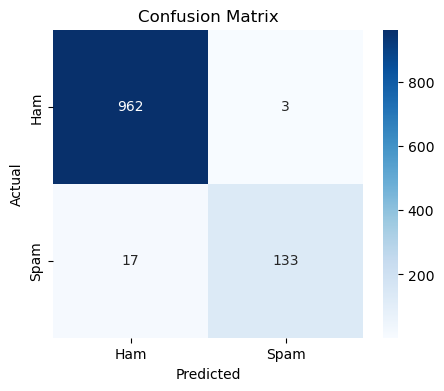

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using your trained model
y_pred = model_MultiNB.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Classification report (includes precision, recall, f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [67]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Fit scikit-learn models
sk_model = MultinomialNB()
cb_model = ComplementNB()

sk_model.fit(X_train, y_train)
cb_model.fit(X_train, y_train)

# Predict
y_pred_custom = model_MultiNB.predict(X_test)
y_pred_sk = sk_model.predict(X_test)
y_pred_cb = cb_model.predict(X_test)



--- Custom MultiNB ---
Accuracy: 0.9820627802690582
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       965
        Spam       0.98      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



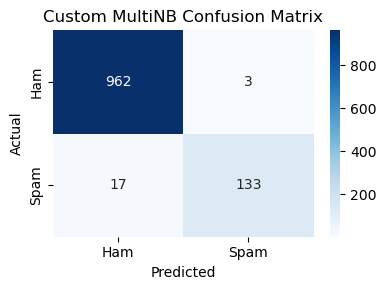


--- Sklearn MultinomialNB ---
Accuracy: 0.9820627802690582
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       965
        Spam       0.98      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



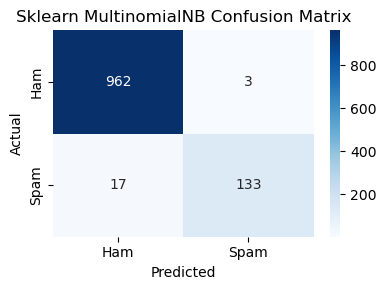


--- Sklearn ComplementNB ---
Accuracy: 0.9542600896860987
              precision    recall  f1-score   support

         Ham       0.99      0.96      0.97       965
        Spam       0.79      0.91      0.84       150

    accuracy                           0.95      1115
   macro avg       0.89      0.93      0.91      1115
weighted avg       0.96      0.95      0.96      1115



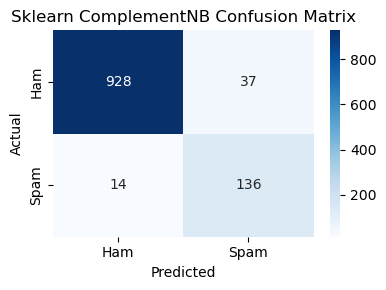

In [68]:
def report_and_cm(y_true, y_pred, name):
    print(f"\n--- {name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["Ham", "Spam"]))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Generate reports
report_and_cm(y_test, y_pred_custom, "Custom MultiNB")
report_and_cm(y_test, y_pred_sk, "Sklearn MultinomialNB")
report_and_cm(y_test, y_pred_cb, "Sklearn ComplementNB")


C:\Users\lenovo\AppData\Local\Temp\ipykernel_19448\24198226.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=values, palette='Set2')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_19448\24198226.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=values, palette='Set2')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_19448\24198226.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=values, palette='Set2')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_19448\24198226.py:20: FutureWarning: 

Passing `palette

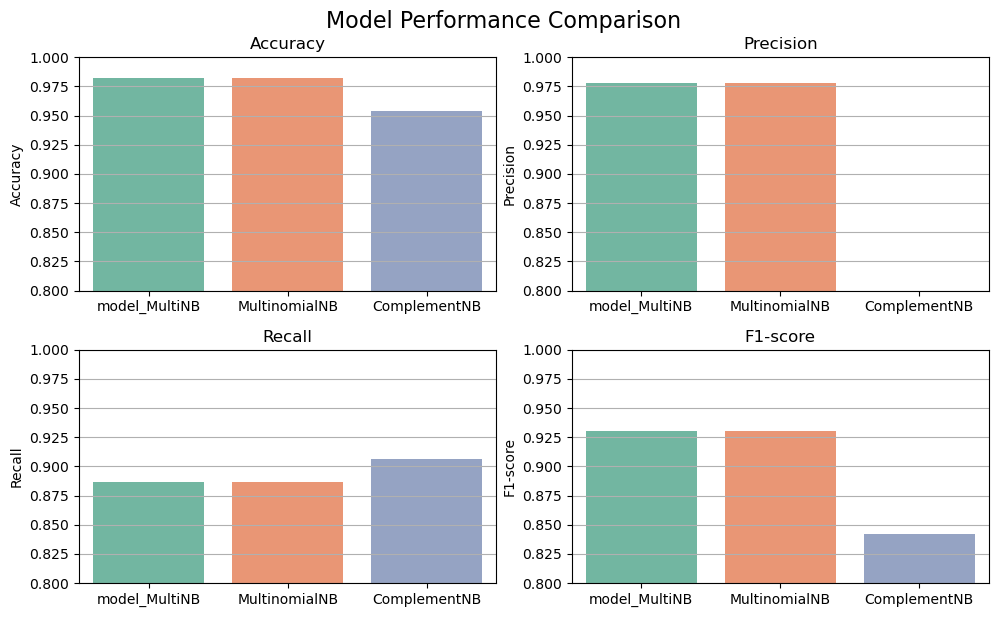

In [72]:
# Metric comparison
models = ['model_MultiNB', 'MultinomialNB', 'ComplementNB']
y_preds = [y_pred_custom, y_pred_sk, y_pred_cb]

def calc_metrics(y_true, y_preds):
    scores = {"Accuracy": [], "Precision": [], "Recall": [], "F1-score": []}
    for y_pred in y_preds:
        scores["Accuracy"].append(accuracy_score(y_true, y_pred))
        scores["Precision"].append(precision_score(y_true, y_pred))
        scores["Recall"].append(recall_score(y_true, y_pred))
        scores["F1-score"].append(f1_score(y_true, y_pred))
    return scores

scores = calc_metrics(y_test, y_preds)

# Plot
plt.figure(figsize=(10,6))
for i, (metric, values) in enumerate(scores.items()):
    plt.subplot(2,2,i+1)
    sns.barplot(x=models, y=values, palette='Set2')
    plt.title(metric)
    plt.ylim(0.8, 1)
    plt.ylabel(metric)
    plt.grid(axis='y')

plt.tight_layout()
plt.suptitle("Model Performance Comparison", fontsize=16, y=1.02)
plt.show()


In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def train_evaluate_multinb(X_train, X_test, y_train, y_test):
    """
    Train and evaluate a Multinomial Naive Bayes classifier using sklearn.

    Parameters:
    -----------
    X_train : array-like (n_samples_train, n_features)
        Training data (tokenized/count vectorized or TF-IDF transformed).
    X_test : array-like (n_samples_test, n_features)
        Test data (same preprocessing as training).
    y_train : array-like (n_samples_train,)
        Training labels.
    y_test : array-like (n_samples_test,)
        Test labels.

    Returns:
    --------
    model : trained MultinomialNB object
    y_pred : array of predicted labels for X_test
    """
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation Report
    print("\n--- Sklearn MultinomialNB ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap="Blues")
    plt.title("Confusion Matrix - MultinomialNB")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return model, y_pred



--- Sklearn MultinomialNB ---
Accuracy: 0.9757847533632287
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       965
           1       0.90      0.92      0.91       150

    accuracy                           0.98      1115
   macro avg       0.94      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



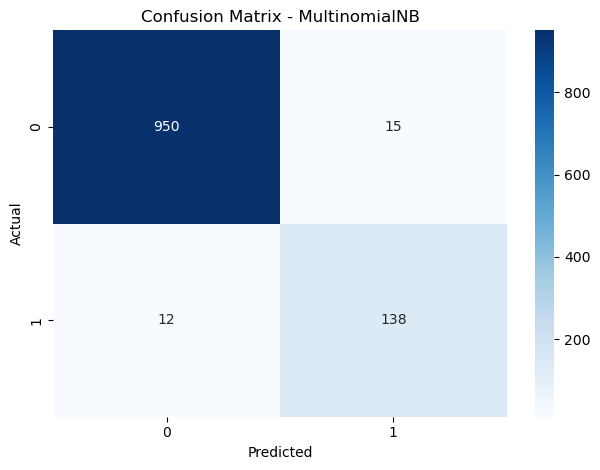

In [54]:
model, y_pred = train_evaluate_multinb(X_train, X_test, y_train, y_test)


In [73]:
from sklearn.metrics import confusion_matrix

def cost_sensitive_risk(y_true, y_pred, cost_fn=5, cost_fp=1):
    """
    Computes total and average risk using a cost-sensitive confusion matrix.

    Parameters:
    -----------
    y_true : array-like
        Ground truth labels (0 for ham, 1 for spam)
    y_pred : array-like
        Predicted labels (0 or 1)
    cost_fn : int or float
        Cost of false negatives (spam predicted as ham)
    cost_fp : int or float
        Cost of false positives (ham predicted as spam)

    Returns:
    --------
    total_risk : float
        Total cost over all predictions
    avg_risk : float
        Average cost per prediction
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_risk = cost_fn * fn + cost_fp * fp
    avg_risk = total_risk / len(y_true)
    return total_risk, avg_risk

# Evaluate risks
models = {
    "Custom MultiNB": y_pred_custom,
    "sklearn MultiNB": y_pred_sk,
    "ComplementNB": y_pred_cb
}

for name, preds in models.items():
    total, avg = cost_sensitive_risk(y_test, preds)
    print(f"{name:20s} | Total Risk: {total:.0f} | Average Risk: {avg:.4f}")


Custom MultiNB       | Total Risk: 88 | Average Risk: 0.0789
sklearn MultiNB      | Total Risk: 88 | Average Risk: 0.0789
ComplementNB         | Total Risk: 107 | Average Risk: 0.0960
